In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [6]:
import numpy
from numba import njit

def inverse(A):
    dim = A.shape[0]
    L, U = LUDecomposition(A)
    Y = numpy.eye(dim)
    for i in range(1, dim):
        for j in range(i):
            sum = L[i][j]
            for k in range(j+1, i):
                sum += L[i][k] * Y[k][j]
            Y[i][j] = -sum
    A_inverse = numpy.zeros((dim, dim))
    for i in range(dim-1, -1, -1):
        for j in range(dim):
            sum = 0
            for k in range(i+1, dim):
                sum += U[i][k] * A_inverse[k][j]
            A_inverse[i][j] = (Y[i][j] - sum) / U[i][i]
    return A_inverse

def LUDecomposition(A):
    dim = A.shape[0]
    L = numpy.zeros((dim, dim))
    U = numpy.zeros((dim, dim))
    for i in range(dim):
        for j in range(i):
            sum = 0
            for k in range(j):
                sum += L[i][k] * U[k][j]
            L[i][j] = (A[i][j] - sum) / U[j][j]
        L[i][i] = 1
        for j in range(i, dim):
            sum = 0
            for k in range(i):
                sum += L[i][k] * U[k][j]
            U[i][j] = A[i][j] - sum
    return L, U

In [7]:
def load_data(path):
    x=[]
    y=[]
    with open(path, 'r') as f:
        for line in f.readlines():
            datapoint = line.split(' ')
            x.append(float(datapoint[0]))
            y.append(float(datapoint[1]))
    x = np.array(x)
    y = np.array(y)
    return x,y

In [16]:
def show(x_line, mean_predict, variance_predict, X, y , alpha=1, l=1):
    plt.figure(figsize=(15,6))
    plt.plot(x_line, mean_predict, 'orange', label='mean')
    plt.fill_between(x_line,
                     mean_predict+2*variance_predict,
                     mean_predict-2*variance_predict, 
                     facecolor='lightpink',
                     label='confidence')
    plt.xlim(-60, 60)
    plt.title("alpha={:.2f}, length_scale={:.2f}".format(alpha,l))
    plt.scatter(X, y, c='k', marker='x',  label='data')
    plt.legend(loc='lower left')
    plt.show()

# Part1: 
Apply Gaussian Process Regression to predict the distribution of f and visualize the result. Please use a rational quadratic kernel to compute
similarities between different points.

Details of the visualization:
- Show all training data points.
- Draw a line to represent the mean of f in range [-60,60].
- Mark the 95% confidence interval of f.

(You can use matplotlib.pyplot to visualize the result, e.g. use
matplotlib.pyplot.fill_between to mark the 95% confidence interval, or
you can use any other package you like.)

![conditional](img/prediction_new.PNG)

## 1. Rational quadratic kernal

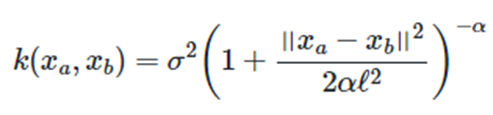

In [8]:
def kernel(X_a, X_b, alpha, l):
    # :param X_a: (n) ndarray
    # :param X_b: (m) ndarray
    # :return: (n,m)  ndarray
    square_error = np.power(X_a.reshape(-1,1) - X_b.reshape(1,-1), 2.0)
    kernel = np.power(1 + square_error/(2 * alpha * l ** 2), -alpha)

    return kernel

## 2. Conditional


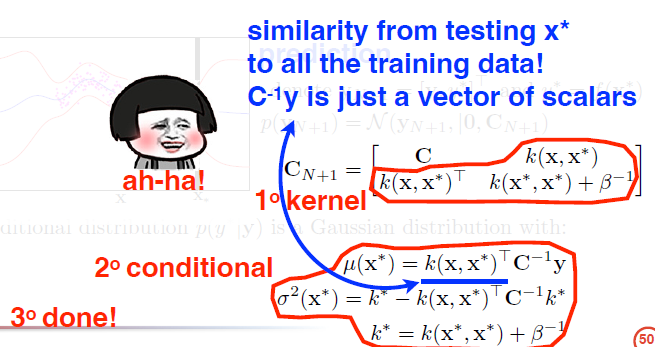

In [9]:
def predict(x_line, X, y, C, beta, alpha=1, l=1):

    # :param x_line: sampling in linspace(-60,60)
    # :param X: (n) ndarray
    # :param y: (n) ndarray
    # :param C: (n,n) ndarray
    # :param beta:
    # :return: (len(x_line),1) ndarray, (len(x_line),len(x_line)) ndarray

    m = len(x_line)
    k_x_xs = kernel(X, x_line, alpha=1, l=1)
    ks     = kernel(x_line, x_line, alpha=1, l=1) + (1 / beta) * np.identity(m)
    
    means = k_x_xs.T @ inverse(C) @ y.reshape(-1,1)
    variances = ks - k_x_xs.T @ inverse(C) @ k_x_xs

    return means, variances

## 3. Done

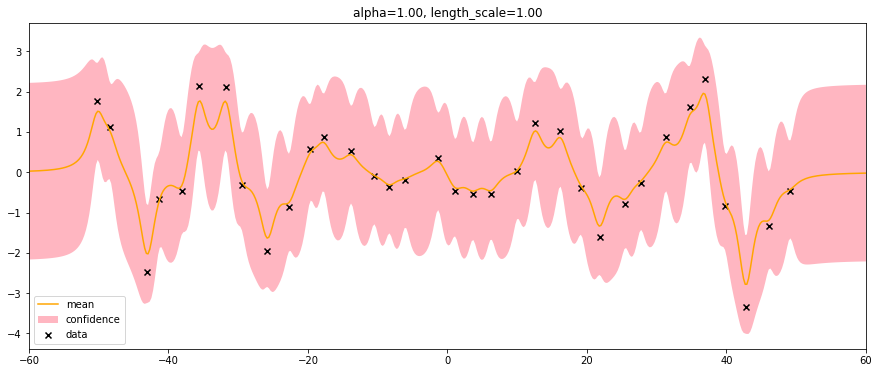

In [17]:
path = '/content/drive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW5_1204/ML_HW05/data/input.data'
X, y = load_data(path)
beta = 5
# kernel
C = kernel(X, X, alpha=1, l=1) + 1 / beta * np.identity(len(X))

# mean and variance in range[-60,60]
x_line = np.linspace(-60, 60, num=500)
mean_predict, variance_predict = predict(x_line, X, y, C, beta, alpha=1, l=1)
mean_predict = mean_predict.reshape(-1)
variance_predict = np.sqrt(np.diag(variance_predict))

# plot
show(x_line, mean_predict, variance_predict, X, y, alpha=1, l=1)

# Part2: 
Optimize the kernel parameters by minimizing negative marginal log-likelihood, and visualize the result again. (You can use scipy.optimize.minimize to optimize the parameters.)


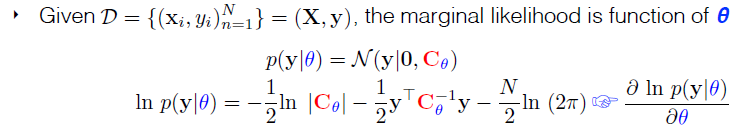

In [18]:
#  when minimum loglikelihood we can find alpha and l 
def fun(args3):

    # :param args:  X, y, beta
    # :return: Optimize alpha, l

    X, y, beta = args3
    y = y.reshape(-1,1)   # y:(n,1)
    def loglikelihood(x0):
        C = kernel(X, X, alpha=x0[0], l=x0[1]) + (1 / beta) * np.identity(len(X))
        v = 0.5 * np.log(np.linalg.det(C)) + \
            0.5 *  (y.T @ inverse(C) @ y) + \
            0.5 * len(X) * np.log(2 * np.pi)
        return v[0]

    return loglikelihood

alpha:  430.3221548899712
length_scale:  2.965286588272608


<ipython-input-19-7a477c8b162e>:29: RuntimeWarning: invalid value encountered in sqrt
  variance_predict = np.sqrt(np.diag(variance_predict))


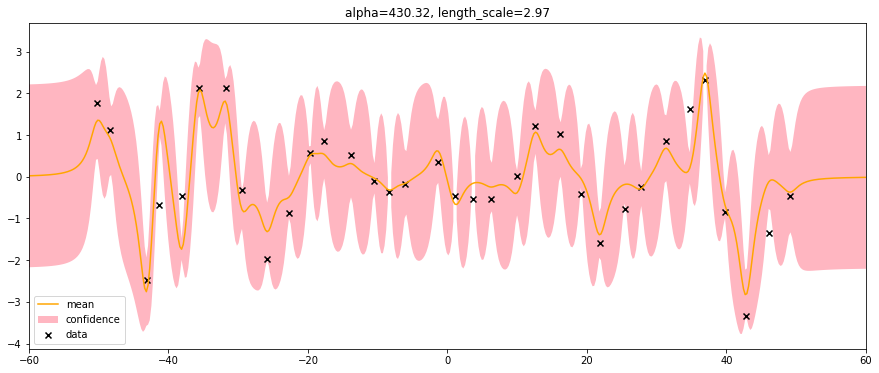

In [19]:
path = '/content/drive/MyDrive/01_GMBA/3rd_semester(2022)/01-2_PM & 04-1_Machine Learning/HW5_1204/ML_HW05/data/input.data'
X, y = load_data(path)
beta = 5

args = (X, y, beta)
objective_value = 1e9
inits = [0.01, 0.1, 0, 10, 100]
for init_alpha in inits:
    for init_length_scale in inits:
        res = minimize(fun = fun(args),
                       x0 = np.asarray([init_alpha, init_length_scale]), 
                       bounds=((1e-5,1e5),(1e-5,1e5)))

        if res.fun < objective_value:
            objective_value = res.fun
            alpha_optimize,length_scale_optimize = res.x
print('alpha: ', alpha_optimize)
print('length_scale: ', length_scale_optimize)

# kernel
C = kernel(X, X, alpha=alpha_optimize, l=length_scale_optimize) + 1 / beta * np.identity(len(X))

# mean and variance in range[-60,60]
x_line = np.linspace(-60, 60, num=500)
mean_predict, variance_predict = predict(x_line, X, y, C, beta, 
                                         alpha=alpha_optimize, 
                                         l=length_scale_optimize)
mean_predict = mean_predict.reshape(-1)
variance_predict = np.sqrt(np.diag(variance_predict))

# plot
show(x_line, mean_predict, variance_predict, X, y,  alpha=alpha_optimize, l=length_scale_optimize)

# Observation

1.	Result 2 is unquestionably superior to Result 1.
2.	The results show that the gaussian process has a better level of confidence in its predictions when using training data points. Gaussian processes may nevertheless produce accurate guesses in the absence of training data. However, the Gaussian process can scarcely generate any predictions in an interval with no training data. Our 95% confidence region is, therefore, substantially more significant than other parts as a result.
3.	The variation in the rational quadratic function, while there, is unimportant. This parameter, which is simply a scaling factor, is present at the front of every kernel. Variance is the function's deviation from its mean.
4.	If the parameters are incorrect, it could produce pretty poor results.
